In [1]:
import pytest
import numpy as np
import pandas as pd
import anndata as an
import scanpy as sc
from scipy.sparse import csr_matrix
from matplotlib import pyplot as plt

import torch
import warnings

import sys

sys.path.insert(0, '../src')
import scVital as scVt

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
writeDir = "../data"
tissue = "muscle"

species1 = "human"
adataFile1 = f'{writeDir}/{tissue}Human_DeM_QC.h5ad'

species2 = "mouse"
adataFile2a = f'{writeDir}/{tissue}Mouse_QC.h5ad'
adataFile2b = f'{writeDir}/{tissue}Mouse_DeM_QC.h5ad'


In [3]:
adata1 = sc.read_h5ad(adataFile1)

In [4]:
adata2 = sc.read_h5ad(adataFile2a)
adata3 = sc.read_h5ad(adataFile2b)

In [5]:
adata = scVt.mg.mergeAdatas([adata1,  adata3]) #adata2,

/Users/jonathanrub/Documents/school/cornell/scVital/vignettes/../src/scVital/merging.py:35: UserWarning: No species given, inferring them
  warnings.warn("No species given, inferring them")
/Users/jonathanrub/Documents/school/cornell/scVital/vignettes/../src/scVital/merging.py:47: UserWarning: Species inferred: ['human', 'mouse']
  warnings.warn(f"Species inferred: {species}")
/Users/jonathanrub/Documents/school/cornell/scVital/vignettes/../src/scVital/merging.py:50: UserWarning: No homology given, inferring them
  warnings.warn("No homology given, inferring them")
/Users/jonathanrub/Documents/school/cornell/scVital/vignettes/../src/scVital/merging.py:67: UserWarning: Data not log normalized, calculating now
  warnings.warn("Data not log normalized, calculating now")
/Users/jonathanrub/Documents/school/cornell/scVital/vignettes/../src/scVital/merging.py:78: UserWarning: No names given, inferring them
  warnings.warn("No names given, inferring them")
/Users/jonathanrub/Documents/school/

In [6]:
batchKey = "species"
sc.pp.highly_variable_genes(adata, batch_key=batchKey)

2019
802


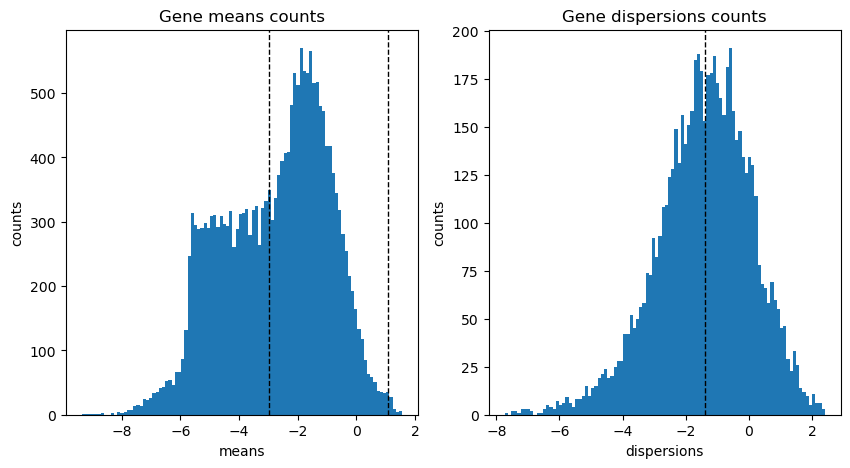

In [7]:
minMean = 0.05
maxMean = 2.9
minDisp = 0.25

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

means = adata.var[["means"]][adata.var[["means"]] > np.exp(-14)]#adata.var[["means"]],
axs[0].hist(np.log(means), bins=100)#, log=True),
axs[0].axvline(np.log(minMean), color='k', linestyle='dashed', linewidth=1)
axs[0].axvline(np.log(maxMean), color='k', linestyle='dashed', linewidth=1)
axs[0].set_title('Gene means counts')
axs[0].set_xlabel('means')
axs[0].set_ylabel('counts')

dispNorm = adata.var[["dispersions_norm"]][adata.var[["dispersions_norm"]] > np.exp(-8)]#adata.var[["means"]],
axs[1].hist(np.log(dispNorm), bins=100)#, log=True),
axs[1].axvline(np.log(minDisp), color='k', linestyle='dashed', linewidth=1)
axs[1].set_title('Gene dispersions counts')
axs[1].set_xlabel('dispersions')
axs[1].set_ylabel('counts')

sc.pp.highly_variable_genes(adata, min_disp=minDisp, min_mean=minMean, max_mean=maxMean, batch_key=batchKey)
print(sum(adata.var.highly_variable))
print(sum(adata.var.highly_variable_intersection))

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
adata.raw = adata
adata = adata[:, np.logical_and(adata.var.highly_variable, np.logical_not(adata.var.mt))]

In [9]:
setupData = {
    'adata': adata,
    'batchLabel': 'species',
    'miniBatchSize': 1024,
    'numEpoch': 50,
    'learningRate': 1e-3,
    'hid1': 1024,
    'hid2': 128,
    'latentSize': 12,
    'discHid': 6,
    'reconCoef': 2e0,
    'klCoef': 5e-2,
    'discCoef': 1e0,
    'discIter': 5,
    'earlyStop': 1e-2,
    'train': False,
    'seed': 18,
    'verbose': True
}

In [10]:
scVitalModel = scVt.makeScVital(setupData['adata'], setupData['batchLabel'], setupData['miniBatchSize'], setupData['numEpoch'], setupData['learningRate'],
        setupData['hid1'], setupData['hid2'], setupData['latentSize'], setupData['discHid'], 
        setupData['reconCoef'], setupData['klCoef'], setupData['discCoef'], setupData['discIter'], 
        setupData['earlyStop'], setupData['train'], seed=setupData['seed'], verbose=setupData['verbose']
    )
print(scVitalModel)

Model Parameters:
adata: View of AnnData object with n_obs × n_vars = 25993 × 2019
    obs: 'sampleID', 'nFeature_RNA', 'nCount_RNA', 'percent_mito', 'cell_annotation', '10x_chemistry', 'cell_annotation.1', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'species', 'nUMI', 'nGene', 'injury', 'dataset'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mt'
    uns: 'hvg'
batchLabel: species
miniBatchSize: 1024
numEpoch: 50
learningRate: 0.001
reconCoef: 322.4468948524702
klCoef: 0.05
discCoef: 1.0
discIter: 5
earlyStop: 0.01
seed: 18
verbose: True
numSpeices: 2
layerDims: [2019, 1024, 128, 12]
inDiscriminatorDims: [12, 6]


In [11]:
scVitalModel.runTrainScVital()

Epoch=0, batch=0, discr=0.7667, total=280.6794, recon=279.9033, trick=0.7761, klDiv=0.0000
Epoch=0, batch=8, discr=0.6272, total=149.4594, recon=148.7122, trick=0.7471, klDiv=0.0000
Epoch=0, batch=16, discr=0.5831, total=129.6678, recon=128.9008, trick=0.7670, klDiv=0.0000
Epoch=0, batch=24, discr=0.5574, total=121.1849, recon=120.3875, trick=0.7974, klDiv=0.0000
Epoch=10, batch=0, discr=0.3993, total=65.8716, recon=63.4473, trick=1.0972, klDiv=1.3271
Epoch=10, batch=8, discr=0.4089, total=65.3081, recon=62.8782, trick=1.0921, klDiv=1.3377
Epoch=10, batch=16, discr=0.4042, total=65.0451, recon=62.6097, trick=1.0906, klDiv=1.3448
Epoch=10, batch=24, discr=0.4068, total=64.9990, recon=62.5640, trick=1.0838, klDiv=1.3512
Epoch=20, batch=0, discr=0.3691, total=60.3628, recon=57.5859, trick=1.0846, klDiv=1.6923
Epoch=20, batch=8, discr=0.4006, total=60.5999, recon=57.8481, trick=1.0639, klDiv=1.6879
Epoch=20, batch=16, discr=0.4058, total=60.6394, recon=57.9013, trick=1.0581, klDiv=1.6800
E

In [12]:
print(scVitalModel)

Model Parameters:
adata: AnnData object with n_obs × n_vars = 25993 × 2019
    obs: 'sampleID', 'nFeature_RNA', 'nCount_RNA', 'percent_mito', 'cell_annotation', '10x_chemistry', 'cell_annotation.1', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'species', 'nUMI', 'nGene', 'injury', 'dataset'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mt'
    uns: 'hvg'
    obsm: 'X_scVital'
    layers: 'scVitalRecon'
batchLabel: species
miniBatchSize: 1024
numEpoch: 50
learningRate: 0.001
reconCoef: 322.4468948524702
klCoef: 0.05
discCoef: 1.0
discIter: 5
earlyStop: 0.01
seed: 18
verbose: True
numSpeices: 2
layerDims: [2019, 1024, 128, 12]
inDiscriminatorDims: [12, 6]


In [13]:
adata = scVitalModel.getAdata()

In [14]:
umapKey = "scVitalModel"
neighborsKey = "scVitalModel"
pcaRep = "X_scVital"

sc.pp.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_pcs=scVitalModel.getLatentSize(), use_rep=pcaRep, key_added=umapKey)
sc.tl.umap(adata, neighbors_key = umapKey)
sc.tl.leiden(adata, resolution=0.1, key_added = neighborsKey, neighbors_key = umapKey)#, flavor="igraph", n_iterations=2,  directed=False)


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-pac

In [15]:
annoDict = {'ICAM1+ SELE+ VCAM1+ Endothelial': "Endo",
 'CLDN5+ PECAM1+ Endothelial': "Endo",
 'RGS5+ MYL9+ Pericytes': "Peri",
 'APOD+ CFD+ PLAC9+ Adipocytes': "Fibro",
 'PAX7low MYF5+ MuSCs and progenitors': "MuSCs",
 'ACTA2+ MYH11+ MYL9+ Smooth muscle cells': "smooth",
 'C1QA+ CD74+ Macrophages': "Macro",
 'IL7R+ PTPRC+ NKG7+ B/T/NK cells': "Imm",
 'COL1A1+ Fibroblasts': "Fibro",
 'CD36+ VWF+ Platelets': "Endo",
 'FBN1+ MFAP5+ CD55+ Fibroblasts': "Fibro",
 'ACTA1+ Mature skeletal muscle': "skel",
 'DCN+ GSN+ MYOC+ Fibroblasts': "Fibro",
 'S100A9+ LYZ+ Inflammatory macrophages': "Macro",
 'PAX7+ DLK1+ MuSCs and progenitors': "MuSCs",
 #'HBA1+ Erythroblasts':  "eryth",
 #nan: 4287,
 'MuSCs and progenitors': "MuSCs",
 'Endothelial': "Endo",
 'Mature skeletal muscle': "skel",
 'Neural/Glial/Schwann cells': "neural",
 'FAPs': "Fibro",
 'Smooth muscle cells': "smooth",
 'Resident Macrophages/APCs': "Macro",
 'Tenocytes': "teno",
 'B/T/NK cells': "Imm"}
adata = adata[adata.obs["cell_annotation"] != "HBA1+ Erythroblasts"]
adata.obs["anno"]=pd.Categorical([ct if pd.isna(ct) else annoDict[ct] for ct in adata.obs["cell_annotation"]])

/var/folders/nc/t9t85q_94q7g4tf0gz83qts40000gn/T/ipykernel_51011/1647637988.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["anno"]=pd.Categorical([ct if pd.isna(ct) else annoDict[ct] for ct in adata.obs["cell_annotation"]])


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


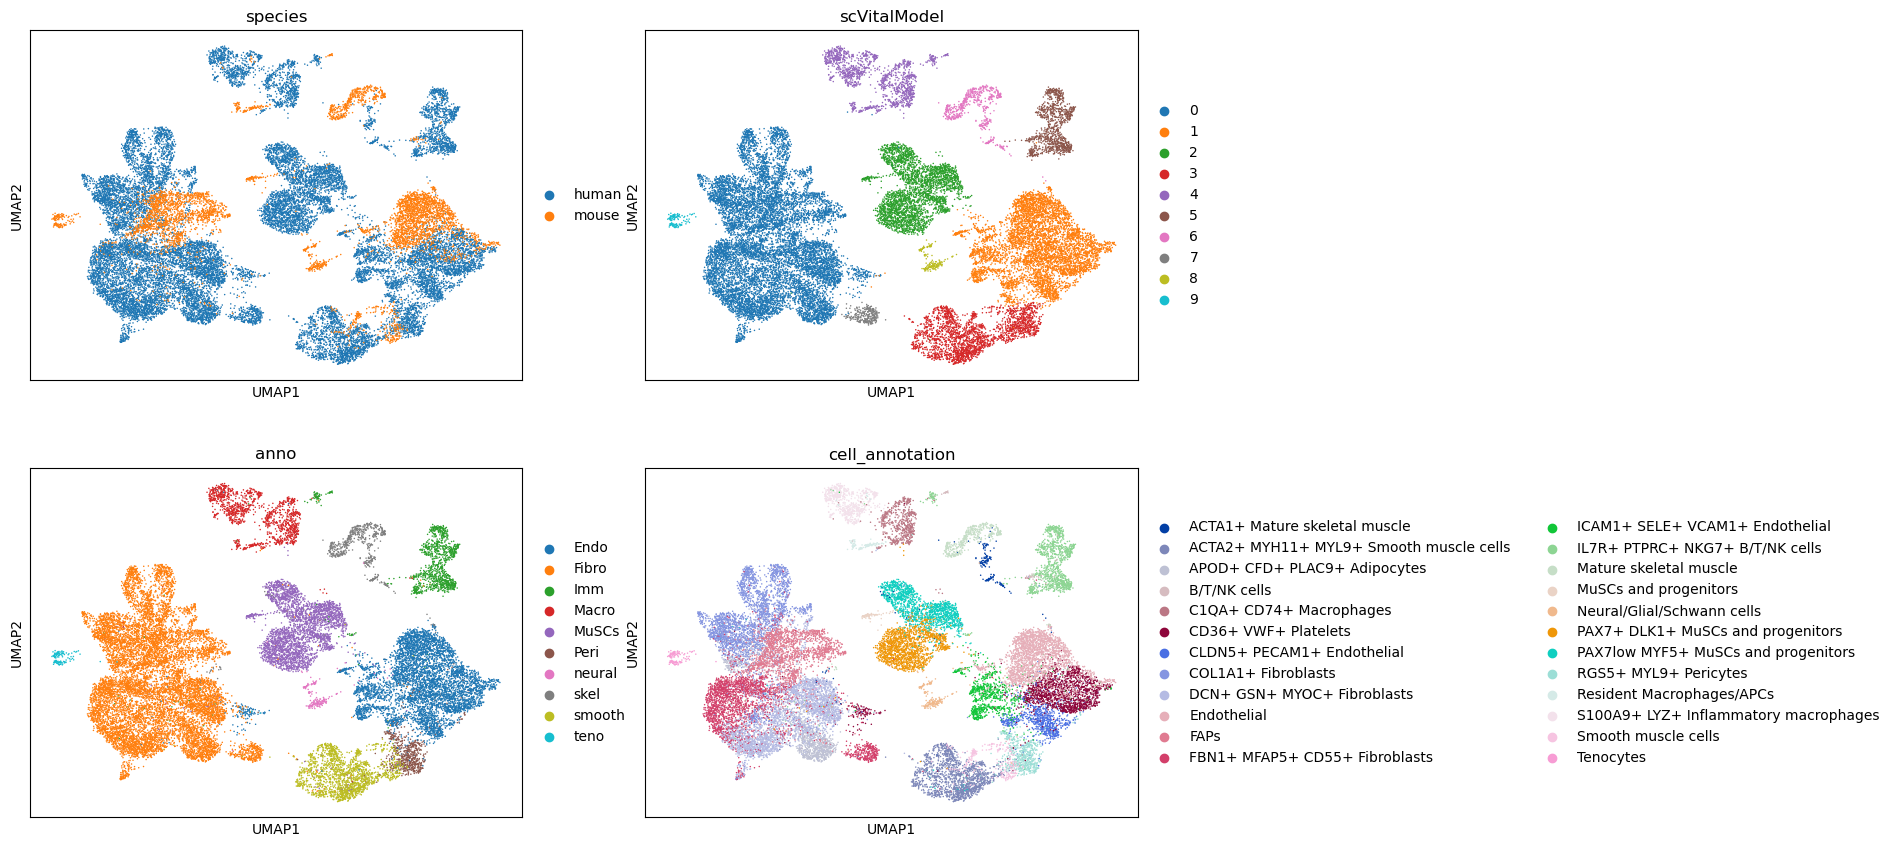

In [16]:
sc.pl.umap(adata, color = ["species",neighborsKey,"anno","cell_annotation"], ncols = 2)


In [17]:
adata.uns["pairs"] = [['ACTA1+ Mature skeletal muscle','Mature skeletal muscle'],
['ACTA2+ MYH11+ MYL9+ Smooth muscle cells','Smooth muscle cells'],
['IL7R+ PTPRC+ NKG7+ B/T/NK cells', 'B/T/NK cells'],
['APOD+ CFD+ PLAC9+ Adipocytes', 'FAPs'],
['COL1A1+ Fibroblasts','FAPs'],
['DCN+ GSN+ MYOC+ Fibroblasts', 'FAPs'],
['FBN1+ MFAP5+ CD55+ Fibroblasts', 'FAPs'],
['RGS5+ MYL9+ Pericytes',  'Endothelial'],
['CD36+ VWF+ Platelets',  'Endothelial'],
['CLDN5+ PECAM1+ Endothelial', 'Endothelial'],
['ICAM1+ SELE+ VCAM1+ Endothelial','Endothelial'],
['PAX7+ DLK1+ MuSCs and progenitors','MuSCs and progenitors'],
['PAX7low MYF5+ MuSCs and progenitors', 'MuSCs and progenitors'],
['C1QA+ CD74+ Macrophages', 'Resident Macrophages/APCs'],
['S100A9+ LYZ+ Inflammatory macrophages','Resident Macrophages/APCs']]

In [19]:
cellTypeLabel="cell_annotation"
latent="X_scVital"
batchName="species"

clustDist, lssAUC, totalDist, allCellTypes, ctPairs = scVt.lss.calcPairsLSS(adata, latent=latent, batchName=batchName, cellTypeLabel=cellTypeLabel)
print(lssAUC)

0.9849673202614379


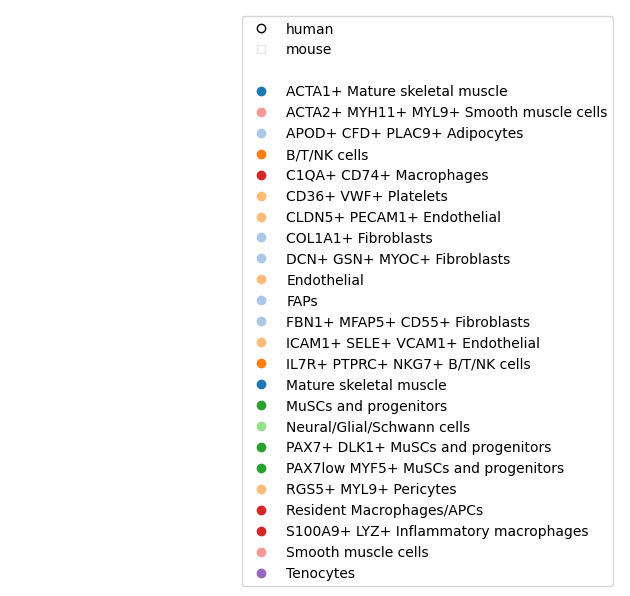

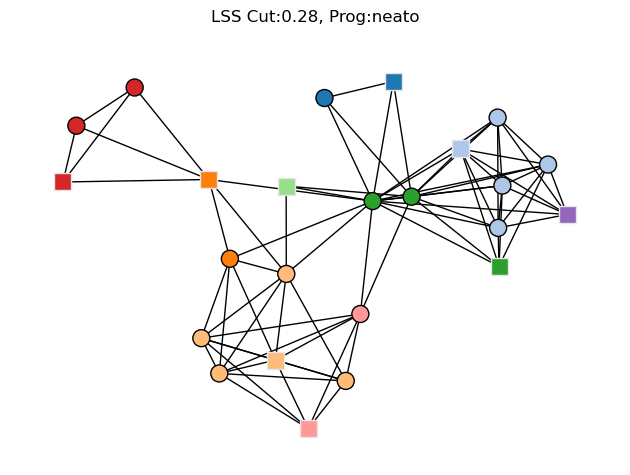

In [20]:
#
batchDict, annoToColorDict = scVt.lss.plotGraphLSS(adata, cellTypeLabel, batchName, clustDist, name="muscleTest", 
             ctColors=plt.get_cmap('tab20').colors, btColors=None, shapes="ospx^><.....", 
             prog="neato", wLab=False, qCut = 0.28, plot=True, save=False)

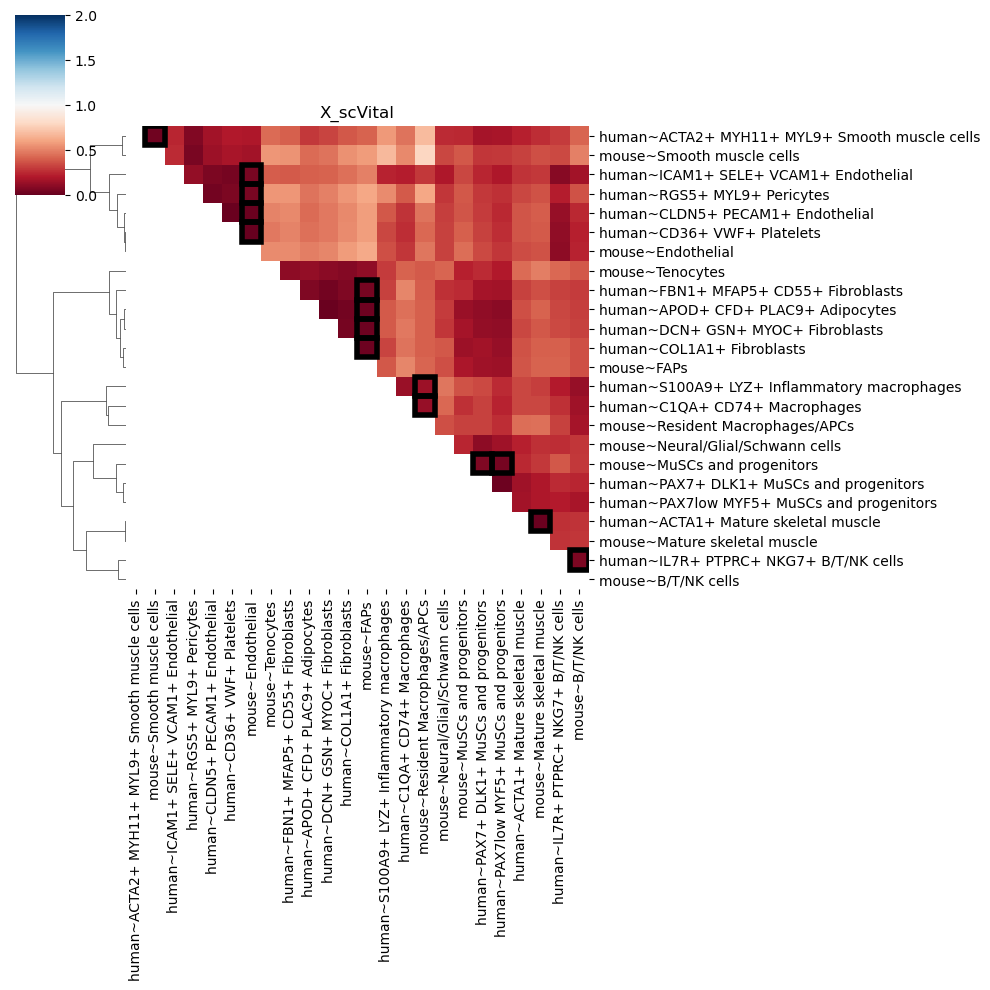

In [21]:
scVt.lss.plotHeatLSS(adata, clustDist, latent, allCellTypes, ctPairs, save=False, plot=True)

In [22]:
from sklearn import metrics
def getClusterMetricDF(labels_true, labels, neighborsKey):
    metricDict = {'Homog': metrics.homogeneity_score,
                  'Compl': metrics.completeness_score,
                  'V-meas': metrics.v_measure_score,
                  'FM': metrics.fowlkes_mallows_score,
                  'ARI': metrics.adjusted_rand_score,
                  'AMI': metrics.adjusted_mutual_info_score
                  }
    metricOut = [f"{metricDict[metricF](labels_true, labels):0.3}" for metricF in metricDict]
    metricDF = pd.DataFrame(metricOut, columns=[neighborsKey], index=list(metricDict.keys()))
    return(metricDF.T)

getClusterMetricDF(adata.obs.anno, adata.obs.scVitalModel, "scVital")

,Homog,Compl,V-meas,FM,ARI,AMI
scVital,0.889,0.901,0.895,0.946,0.927,0.894
